In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import *
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("./Data/EURUSD_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)


df_tech = pd.read_csv("./Data/EURUSD_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)

import sys
import os
sys.path.append("./factors")
import tech_indicators

EURUSD_close = df_tech['PX_LAST'].to_numpy()
EURUSD_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[50]],"RSI":[[10],[50],[100]],"MACD":[[26,12],[12,5]],"ROC":[[2]],"Bollinger_Bands_lower":[[20],[50]],
             "Bollinger_Bands_upper":[[20],[100]],
              "CCI":[[20],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_close,getattr(tech_indicators,key),*value)
    
df_tech.dropna(inplace=True,ignore_index=True)

df_tech_part = df_tech.iloc[:,7:]

df_tech_part["Dates"] = df_tech["Dates"]

df_tech = df_tech_part

df = pd.merge(left=df_Macro,right=df_tech,how="left",on="Dates")

df["2Y spread"] = df['GTDEM2Y Govt']-df["USGG2YR Index"]
df["10Y spread"] = df['GTDEM10Y Govt']-df["USGG10YR Index"]
df["30Y spread"] = df['GTDEM10Y Govt']-df['USGG30YR Index']

df

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,EURUSDV1W Curncy,EURUSDV1M Curncy,EURUSDV1Y Curncy,EURUSD25R1M Curncy,EURON Curncy,...,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100,2Y spread,10Y spread,30Y spread
0,10/3/2003,1.1695,1.1722,1.1554,1.1580,11.3500,11.1500,11.2000,0.7000,-1.055,...,-0.009918,1.103098,1.077703,1.176722,1.195954,90.851777,61.696460,0.9350,0.0113,-0.8855
1,10/6/2003,1.1563,1.1723,1.1535,1.1710,10.6000,11.3500,11.2250,0.7000,-0.335,...,0.011226,1.107282,1.076865,1.178978,1.196111,97.427477,72.851043,0.9132,0.0015,-0.8977
2,10/7/2003,1.1710,1.1814,1.1700,1.1761,11.2500,11.6500,11.4000,0.8000,-0.345,...,0.004355,1.108528,1.075710,1.183082,1.196270,128.930818,102.571822,0.8740,-0.0553,-0.9549
3,10/8/2003,1.1761,1.1840,1.1760,1.1812,11.1250,11.6250,11.3500,0.8000,-0.373,...,0.004336,1.110314,1.074349,1.187306,1.196846,134.577013,114.970487,0.8871,-0.0367,-0.9610
4,10/9/2003,1.1811,1.1860,1.1687,1.1748,11.5000,11.3000,11.2000,0.7750,-1.420,...,-0.005418,1.113640,1.073701,1.189360,1.197023,105.467974,102.902915,0.9229,-0.0376,-0.9608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5421,7/15/2024,1.0903,1.0922,1.0882,1.0894,4.6725,5.0475,6.1700,-0.1475,0.494,...,-0.001192,1.063823,1.067336,1.091007,1.095594,144.435004,102.425147,-1.6645,-1.7594,-1.9871
5422,7/16/2024,1.0894,1.0905,1.0872,1.0899,4.5475,5.0575,6.1750,-0.1450,0.499,...,0.000459,1.063682,1.067392,1.092738,1.095752,118.739548,94.120244,-1.6592,-1.7326,-1.9471
5423,7/17/2024,1.0899,1.0948,1.0895,1.0939,5.0075,5.2550,6.1750,-0.1375,0.498,...,0.003670,1.063260,1.067321,1.095110,1.096080,134.613826,126.478733,-1.6669,-1.7386,-1.9558
5424,7/18/2024,1.0939,1.0941,1.0894,1.0897,4.3325,5.0300,6.2175,-0.2125,0.500,...,-0.003839,1.064168,1.067334,1.096152,1.096289,106.594399,107.956277,-1.7104,-1.7721,-1.9917


In [2]:
split_point = int(df.shape[0]*0.9)
df_train = df.iloc[:split_point,:]
df_test = df.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

threshold = threshold_search(y_train,1e-6)

print(threshold)

# You can set the threshold manually

y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))
test_set_value = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = train_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

0.001947
1605
1628
1629


In [3]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.75}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cpu')

net_test.to(device=device,dtype=torch.float64)

net_test.load_state_dict(torch.load("./trained_model/EURUSD_Mix_LSTM.pth"))

net_test

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM_Net(
  (LSTM_layer): LSTM(49, 32, batch_first=True, dropout=0.75)
  (linear_stock): Sequential(
    (0): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.75, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResNetBlock(
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout): Dropout(p=0.75, inplace=False)
      (layernorms): ModuleList(
        (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      )
    )
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [4]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

net_test.eval()
predict_raw_probability = F.softmax(net_test(test_set[:][0]),dim=-1)
predict_probability = (torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0])

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]
real_results_2 = torch.where(test_set_value[:][1]>=0,2,0)   #two class result

accuracy_score(real_results,predict_results)

0.421455938697318

In [5]:
act_threshold_rate = np.percentile((predict_probability.detach().numpy()),10)

act_predict_bool = (predict_results != 1) & (predict_probability > act_threshold_rate)
print(f"act threshold rate is: {act_threshold_rate*100}%")
print(f"act times rate is: {len(np.nonzero(act_predict_bool))/len(real_results)*100}%")
act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]
act_real_results_2 = real_results_2[act_predict_bool]

print(f"3-class prediction accuracy is {accuracy_score(act_predict_results,act_real_results)*100}%")



act threshold rate is: 37.763262578646355%
act times rate is: 29.693486590038315%
3-class prediction accuracy is 39.35483870967742%


In [6]:
print(f"2-class prediction accuracy is {accuracy_score(act_predict_results,act_real_results_2)*100}%")

2-class prediction accuracy is 54.19354838709678%


/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


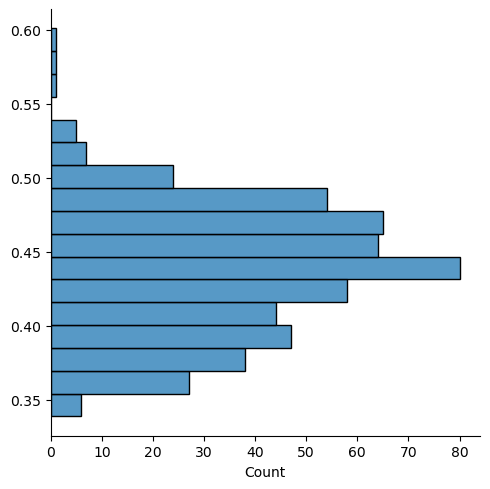

In [7]:
import matplotlib.pyplot as plt
import seaborn

seaborn.displot(y=predict_probability.detach().numpy()
                )

plt.show()

In [8]:
df_test.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'EURUSDV1W Curncy',
       'EURUSDV1M Curncy', 'EURUSDV1Y Curncy', 'EURUSD25R1M Curncy',
       'EURON Curncy', 'EURUSDVON Curncy', 'EUR1M Curncy', 'EUR12M Curncy',
       'DXY Curncy', 'GOLDS Comdty', 'CL1 Comdty', 'FEDL01 Index',
       'LF94TRUU Index', 'USGG2YR Index', 'USGG10YR Index', 'USGG30YR Index',
       'GTDEM2Y Govt', 'GTDEM10Y Govt', 'GTDEM30Y Govt', 'GTFRF2Y Govt',
       'GTFRF10Y Govt', 'GTFRF30Y Govt', 'SPX Index', 'VIX Index',
       'SX5E Index', 'CPI YOY Index', 'EACPI Index', 'Last_Return',
       'Predict_Return', 'SMA_10', 'EMA_50', 'RSI_10', 'RSI_50', 'RSI_100',
       'MACD_26_12', 'MACD_12_5', 'ROC_2', 'Bollinger_Bands_lower_20',
       'Bollinger_Bands_lower_50', 'Bollinger_Bands_upper_20',
       'Bollinger_Bands_upper_100', 'CCI_20', 'CCI_100', '2Y spread',
       '10Y spread', '30Y spread'],
      dtype='object')

In [9]:
df_test.reset_index(inplace=True,drop=True)
df_test_result = df_test.loc[(time_delta-1):,['Dates','Predict_Return','EURON Curncy']].copy()

df_test_result.rename(columns={'EURON Curncy':'carry return'},inplace=True)
df_test_result['carry return'] = df_test_result['carry return']/10000

df_test_result.rename(columns={'Predict_Return':'Real_Return'},inplace=True)

df_test_result

,Dates,Real_Return,carry return
21,7/21/2022,-0.001662,0.000060
22,7/22/2022,0.000685,0.000182
23,7/25/2022,-0.010078,0.000061
24,7/26/2022,0.008204,0.000060
25,7/27/2022,-0.000294,0.000047
...,...,...,...
538,7/15/2024,0.000459,0.000049
539,7/16/2024,0.003670,0.000050
540,7/17/2024,-0.003839,0.000050
541,7/18/2024,-0.001377,0.000050


In [10]:
columns_list = ["predict_down_rate","predict_fluct_rate","predict_up_rate"]

for i in range(len(columns_list)):
    df_test_result[columns_list[i]] = predict_raw_probability[:,i].detach().numpy()
    
df_test_result.set_index("Dates",drop=True,inplace=True)
    
    
df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate
Dates,,,,,
7/21/2022,-0.001662,0.000060,0.359153,0.187065,0.453783
7/22/2022,0.000685,0.000182,0.374689,0.255757,0.369555
7/25/2022,-0.010078,0.000061,0.382504,0.225910,0.391586
7/26/2022,0.008204,0.000060,0.342554,0.235432,0.422015
7/27/2022,-0.000294,0.000047,0.391251,0.204371,0.404378
...,...,...,...,...,...
7/15/2024,0.000459,0.000049,0.279134,0.477821,0.243045
7/16/2024,0.003670,0.000050,0.278801,0.477507,0.243692
7/17/2024,-0.003839,0.000050,0.289192,0.468769,0.242039


In [11]:
# act just as predict result

df_test_result["predict_action"] = np.where(predict_results.detach().numpy()==0,"short",
                                            np.where(predict_results.detach().numpy()==2,"long","no_act"))

df_test_result["pnl_change"] = np.where(predict_results.detach().numpy()==2,
                                        ((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000)
                                        .to_numpy(),
                                        np.where(predict_results.detach().numpy()==0,
                                                 (-((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000)
                                                                                       .to_numpy()),0))

df_test_result["pnl"] = df_test_result["pnl_change"].cumsum()

df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl
Dates,,,,,,,,
7/21/2022,-0.001662,0.000060,0.359153,0.187065,0.453783,long,-0.001802,-0.001802
7/22/2022,0.000685,0.000182,0.374689,0.255757,0.369555,short,-0.000667,-0.002469
7/25/2022,-0.010078,0.000061,0.382504,0.225910,0.391586,long,-0.010217,-0.012686
7/26/2022,0.008204,0.000060,0.342554,0.235432,0.422015,long,0.008064,-0.004622
7/27/2022,-0.000294,0.000047,0.391251,0.204371,0.404378,long,-0.000448,-0.005070
...,...,...,...,...,...,...,...,...
7/15/2024,0.000459,0.000049,0.279134,0.477821,0.243045,no_act,0.000000,0.174366
7/16/2024,0.003670,0.000050,0.278801,0.477507,0.243692,no_act,0.000000,0.174366
7/17/2024,-0.003839,0.000050,0.289192,0.468769,0.242039,no_act,0.000000,0.174366


In [12]:
action_signal = (np.max(predict_raw_probability.detach().numpy(),axis=-1)>act_threshold_rate) & (
    predict_results.detach().numpy() !=1 )

df_test_result["strategy_action"] =  np.where(~action_signal,"no_act",
                                            np.where(predict_results.detach().numpy()==2,"long","short"))

df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action
Dates,,,,,,,,,
7/21/2022,-0.001662,0.000060,0.359153,0.187065,0.453783,long,-0.001802,-0.001802,long
7/22/2022,0.000685,0.000182,0.374689,0.255757,0.369555,short,-0.000667,-0.002469,no_act
7/25/2022,-0.010078,0.000061,0.382504,0.225910,0.391586,long,-0.010217,-0.012686,long
7/26/2022,0.008204,0.000060,0.342554,0.235432,0.422015,long,0.008064,-0.004622,long
7/27/2022,-0.000294,0.000047,0.391251,0.204371,0.404378,long,-0.000448,-0.005070,long
...,...,...,...,...,...,...,...,...,...
7/15/2024,0.000459,0.000049,0.279134,0.477821,0.243045,no_act,0.000000,0.174366,no_act
7/16/2024,0.003670,0.000050,0.278801,0.477507,0.243692,no_act,0.000000,0.174366,no_act
7/17/2024,-0.003839,0.000050,0.289192,0.468769,0.242039,no_act,0.000000,0.174366,no_act


In [13]:
df_test_result["pnl_strategy_change"] = np.where(df_test_result["strategy_action"].to_numpy()=="long",
                                                 ((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000).to_numpy(),
                                        np.where(df_test_result["strategy_action"].to_numpy()=="short",
                                                 -(((df_test_result["Real_Return"]+df_test_result['carry return'])-2/10000).to_numpy()),0))

df_test_result["pnl_strategy"] = df_test_result["pnl_strategy_change"].cumsum()

df_test_result

,Real_Return,carry return,predict_down_rate,predict_fluct_rate,predict_up_rate,predict_action,pnl_change,pnl,strategy_action,pnl_strategy_change,pnl_strategy
Dates,,,,,,,,,,,
7/21/2022,-0.001662,0.000060,0.359153,0.187065,0.453783,long,-0.001802,-0.001802,long,-0.001802,-0.001802
7/22/2022,0.000685,0.000182,0.374689,0.255757,0.369555,short,-0.000667,-0.002469,no_act,0.000000,-0.001802
7/25/2022,-0.010078,0.000061,0.382504,0.225910,0.391586,long,-0.010217,-0.012686,long,-0.010217,-0.012019
7/26/2022,0.008204,0.000060,0.342554,0.235432,0.422015,long,0.008064,-0.004622,long,0.008064,-0.003955
7/27/2022,-0.000294,0.000047,0.391251,0.204371,0.404378,long,-0.000448,-0.005070,long,-0.000448,-0.004403
...,...,...,...,...,...,...,...,...,...,...,...
7/15/2024,0.000459,0.000049,0.279134,0.477821,0.243045,no_act,0.000000,0.174366,no_act,0.000000,0.116220
7/16/2024,0.003670,0.000050,0.278801,0.477507,0.243692,no_act,0.000000,0.174366,no_act,0.000000,0.116220
7/17/2024,-0.003839,0.000050,0.289192,0.468769,0.242039,no_act,0.000000,0.174366,no_act,0.000000,0.116220


In [14]:
# df_test_result.to_csv("./Data/test_result.csv")

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


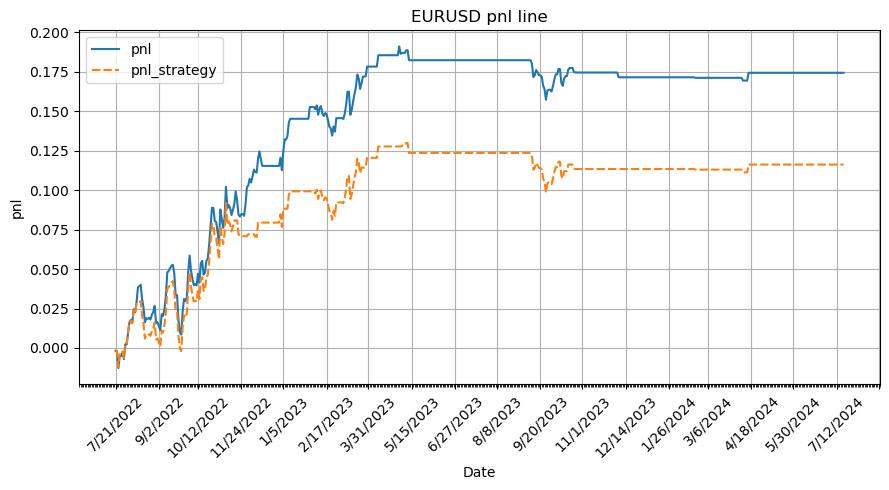

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Plot the DataFrame
plt.figure(figsize=(9, 5))  # Set the figure size
sns.lineplot(data=df_test_result[["pnl","pnl_strategy"]])

# Set major ticks format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set major ticks to every month


# Optionally, set minor ticks format
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(interval=1))  # Set minor ticks to every day

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('pnl')
plt.title('EURUSD pnl line')

# Show grid
plt.grid(True)

# Adjust layout to fit everything
plt.tight_layout()

# Show the plot
plt.show()
